# Questão número 2 da prova
Controle 2 2020/2

Aluno: Jhonatan de Freitas Lang


In [2]:
pip install control

     |████████████████████████████████| 348kB 17.0MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=22d1fd174f88d763394b0e34186479454cba90aceb66fbdc1eecc4d0feadb38d
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [3]:
import numpy as np
import sympy as sp
import control                   
import control.matlab
import math
import cmath
import matplotlib.pyplot as plt
from scipy import linalg

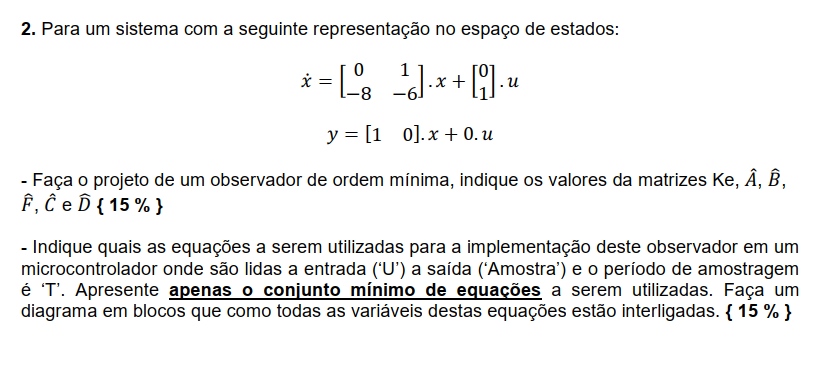

In [4]:
# Declaração de variáveis

K = 0.2;
C = 1000e-6;
L = 10e-3;
R = 5;

tfinal = 1e-3;

# Matrizes de estados cálculadas 

A = np.block([[ 0 , 1 ],[ -8 , -6 ]])
B = np.block([[ 0 ],[ 1 ]])
C = np.block([[1, 0]])
D = 0;

#conversão para função de transferência

# sistema no espaço de estados
sys = control.ss(A,B,C,D);

# convertendo para função de tranferência com a utilização da função ss2tf
G = control.ss2tf(sys);
[[n]],[[d]] = control.tfdata(G);

G

TransferFunction(array([1.]), array([1., 6., 8.]))

In [5]:
# Verificando polos da planta
autovalores_planta, autovetores = linalg.eig(A);
polos_planta = autovalores_planta
polos_planta

array([-2.+0.j, -4.+0.j])

In [6]:
# Matrizes reduzidas
Aaa = A[0,0]
Aab = A[0,1]
Aba = A[1,0]
Abb = A[1,1]

Ba = B[0,0]
Bb = B[1,0]

# Matriz de Controlabilidade do sistema dual para ordem mínima
Mc = control.ctrb(Aab,Abb)
Mc

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc) #número de postos do sistema
rank_Mc

1

A matriz é observável

## projeto do observador de ordem mínima

In [14]:
# Polo do observador, 5 vezes mais rápido do que os polos do controlador

L = -5*abs(polos_planta[1]);

# Ganho do observador
Ke = control.acker(Abb,Aab,[L])
Ke = Ke[0,0]      # Transformando em escalar




Achapeu = Abb-Ke*Aab;
Bchapeu = Achapeu*Ke+Aba-Ke*Aaa
Fchapeu = Bb-Ke*Ba;

Cchapeu = np.matrix('0;1');
Dchapeu = np.block([[1], [Ke]]);


print("L: " + str(L) + "\n")
print("Ke: " + str(Ke) + "\n")
print("Achapeu: " + str(Achapeu) + "\n")
print("Bchapeu: " + str(Bchapeu) + "\n")
print("Fchapeu: " + str(Fchapeu) + "\n")
print("Cchapeu: " + str(Cchapeu) + "\n")
print("Dchapeu: " + str(Dchapeu) + "\n")

L: -20.0

Ke: 14.0

Achapeu: -20.0

Bchapeu: -288.0

Fchapeu: 1.0

Cchapeu: [[0]
 [1]]

Dchapeu: [[ 1.]
 [14.]]



In [23]:
# simulação com equações recursivas
# definindo o intervalo de simulação e o vetor de entrada
Fs = 2000
T = 1/Fs;
tfinal = 5;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, int(Fs*tfinal))
u = np.ones(len(k));

# definindo os vetores
x1 = np.zeros(len(k));
x2 = np.zeros(len(k));
x1_ponto = np.zeros(len(k));
x2_ponto = np.zeros(len(k));
y = np.zeros(len(k));
eta1 = np.zeros(len(k));
eta1_ponto = np.zeros(len(k));
xtil1 = np.zeros(len(k));
xtil2 = np.zeros(len(k));

# condições iniciais (podem ser diferentes de zero)
x1[0] = 0;  #  para k = 0
x2[0] = 0;  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
eta1[0] = 0;  #  para k = 0
eta1_ponto[0] = Fchapeu*u[0];  #  para k = 0



for j in range(1,Kmax-1):
    # sistema original
        # Equações dos integradores
        x1[j]=T*x1_ponto[j-1]+x1[j-1];
        x2[j]=T*x2_ponto[j-1]+x2[j-1];    
        
        # Equação diferencial de estados:  Xponto=A*X+B*U
        x1_ponto[j]=A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
        x2_ponto[j]=A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 

        # Equação de Saída: Y=C*X+D*U
        y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];

    # observador de ordem mínima
        # Equações dos integradores do observador
        eta1[j]=T*eta1_ponto[j-1]+eta1[j-1];
    
        # Equação diferencial de estados do observador
        eta1_ponto[j]=Achapeu*eta1[j]+Bchapeu*y[j]+Fchapeu*u[j];
    
    # Transformação
        # equação de saída do observador de ordem mínima
        xtil1[j]=Cchapeu[0,0]*eta1[j]+Dchapeu[0]*y[j];
        xtil2[j]=Cchapeu[1,0]*eta1[j]+Dchapeu[1]*y[j];

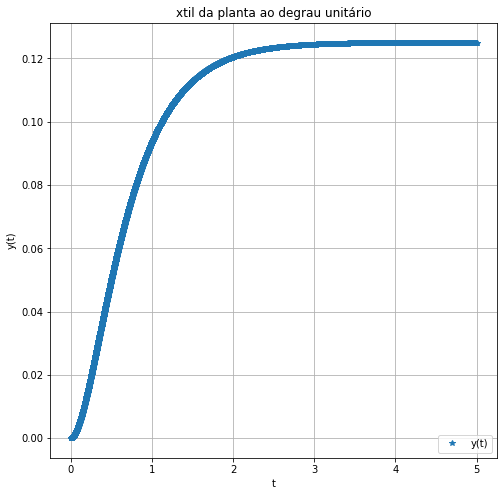

In [25]:
# resposta para entrada ao degrau
fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(8,8)

ax1.plot(k*T,xtil1,'*')
ax1.set_title("xtil da planta ao degrau unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")
ax1.legend(['y(t)'],loc="lower right")
ax1.grid(True,'both')

As equações míinimas para implementação do observador em um microcontrolador seriam:

    # observador de ordem mínima
        # Equações dos integradores do observador
        eta1[j]=T*eta1_ponto[j-1]+eta1[j-1];
    
        # Equação diferencial de estados do observador
        eta1_ponto[j]=Achapeu*eta1[j]+Bchapeu*y[j]+Fchapeu*u[j];
    
    # Transformação
        # equação de saída do observador de ordem mínima
        xtil1[j]=Cchapeu[0,0]*eta1[j]+Dchapeu[0]*y[j];
        xtil2[j]=Cchapeu[1,0]*eta1[j]+Dchapeu[1]*y[j];

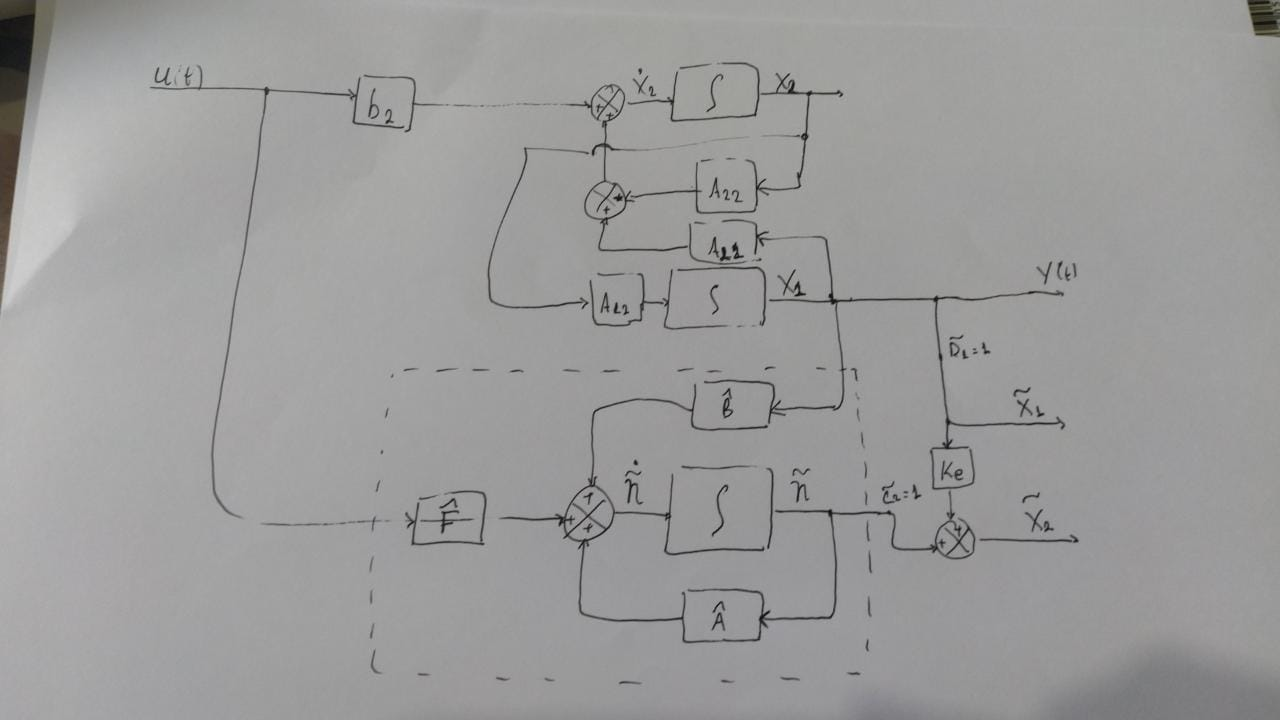